In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
import cv2
import tensorflow as tf

In [ ]:
img_array=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data/surprise/35875.jpg")

In [ ]:
img_array.shape

(48, 48, 3)

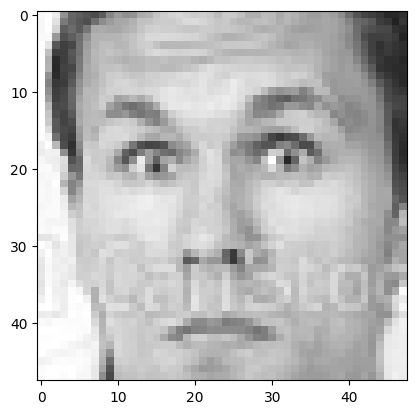

In [ ]:
plt.imshow(img_array)

In [ ]:
datadirectory="/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data"

In [ ]:
classes=["surprise","sad","neutral","happy","fear","disgust","angry"]

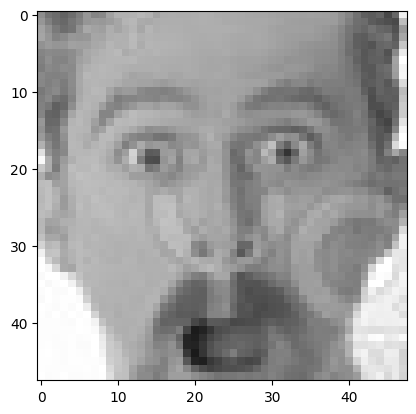

In [ ]:
for category in classes:
  path=os.path.join(datadirectory,category)
  for img in os.listdir(path):
    img_array=cv2.imread(os.path.join(path,img))
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

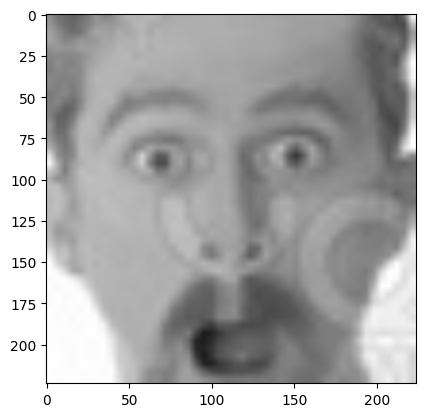

In [ ]:
img_size=224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))

convert images to array

In [ ]:
from logging import exception
traning_data=[]
def create_training_data():
  for category in classes:
    path=os.path.join(datadirectory, category)
    class_num=classes.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(img_size,img_size))
        traning_data.append([new_array,class_num])
      except exception as e:
        pass

In [ ]:
create_training_data()

In [ ]:
print(len(traning_data))

29589


In [ ]:
import random
random.shuffle(traning_data)

In [ ]:
x=[]
y=[]
for features,label in traning_data:
  x.append(features)
  y.append(label)

x=np.array(x).reshape(-1,img_size,img_size,3)

In [ ]:
x.shape

(29589, 224, 224, 3)

In [ ]:
y=np.array(y)

In [ ]:
y.shape

(29589,)

Model training-transfer learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model=tf.keras.applications.MobileNetV2()

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_input=model.layers[0].input
base_output=model.layers[-2].output

In [ ]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
final_output=layers.Dense(128)(base_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(64)(final_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(7,activation='softmax')(final_output)

In [ ]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [ ]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
new_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
y[100]

2

In [ ]:
new_model.fit(x,y,epochs=3)

Epoch 1/3
925/925 [==============================] - 867s 922ms/step - loss: 1.2562 - accuracy: 0.5281
Epoch 2/3
925/925 [==============================] - 808s 873ms/step - loss: 1.0737 - accuracy: 0.5988
Epoch 3/3
925/925 [==============================] - 801s 866ms/step - loss: 1.0018 - accuracy: 0.6250


In [ ]:
new_model.save("mymodel.h5")

In [ ]:
new_model=tf.keras.models.load_model("mymodel.h5")

In [ ]:
frame=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data/surprise/35875.jpg")

In [ ]:
os.path.exists("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data/surprise/35875.jpg")

True

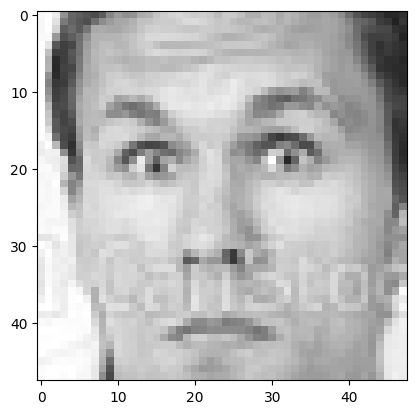

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [ ]:
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

(48, 48)

In [ ]:
faces=faceCascade.detectMultiScale(gray,1.1,4)
for (x,y,w,h) in faces:
  roi_gray=gray[y:y+h,x:x+w]
  roi_color=frame[y:y+h,x:x+w]
  cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
  faces=faceCascade.detectMultiScale(roi_gray)
  if len(faces) == 0:
    print("Face not detected")
  else:
    for (ex,ey,ew,eh) in faces:
      face_roi=roi_color[ey:ey+eh,ex:ex+ew]

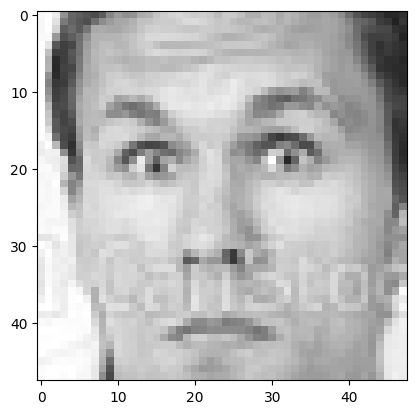

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
final_image=cv2.resize(frame,(224,224))
final_image=np.expand_dims(final_image,axis=0)
final_image=final_image/255.0

In [ ]:
predictions=new_model.predict(final_image)

1/1 [==============================] - 1s 857ms/step


In [ ]:
predictions[0]

array([1.3985352e-03, 6.2411678e-01, 1.2323236e-01, 5.0315373e-03,
       2.2544679e-01, 5.7445426e-10, 2.0774033e-02], dtype=float32)

In [ ]:
np.argmax(predictions)

1